<a href="https://colab.research.google.com/github/satuelisa/CINVESTAV2025/blob/main/appl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working with data that, at first sight, seems to contain more than just plain numbers

Working with images is referred to as *image processing* or *computer vision*. It is easier than it sounds.

Let's access an image available online.

In [1]:
from PIL import Image
import requests
source = 'https://github.com/SCS-Technology-and-Innovation/DACS/blob/main/DTDA/img/canopy.jpg?raw=true'
big = Image.open(requests.get(source, stream = True).raw)

Since the *resolution* is big, we can scale it down to half the original size.

(1000, 672)


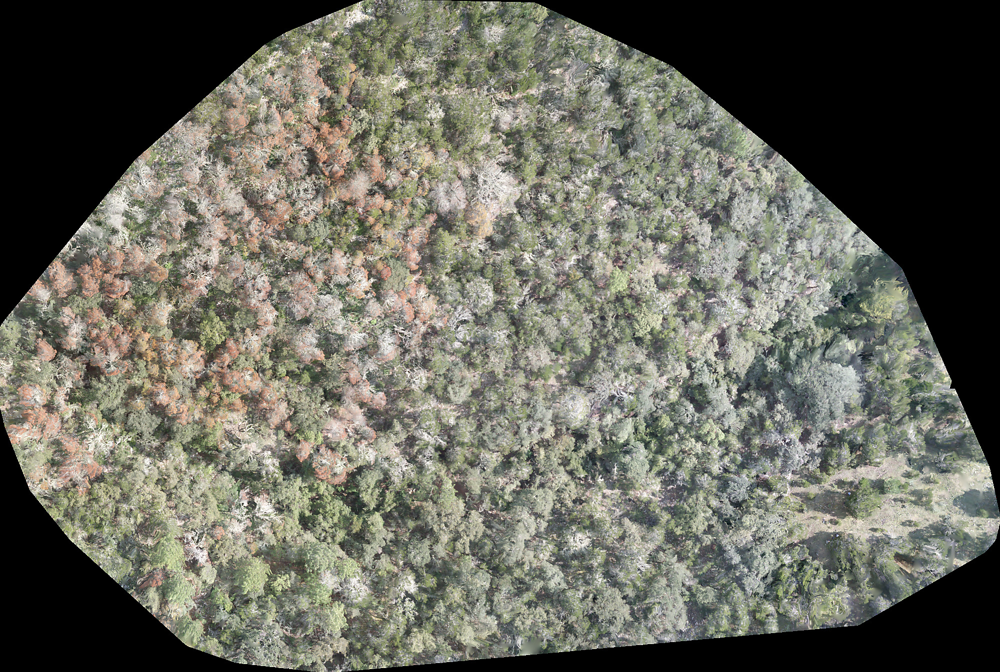

In [4]:
w, h = big.size
whole = big.resize((w // 2, h // 2))
print(whole.size)
display(whole)

Notice how the corners are missing? Let's think of why this would be (as in, how this image has been captured).

Then, let's just chop it up into a small rectangle that will be faster for us to process.

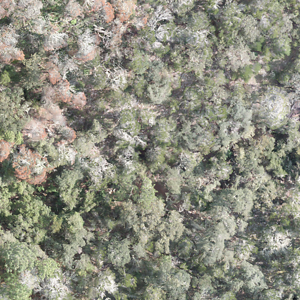

(300, 300)


In [3]:
bb = (300, 300, 600, 600) # just a rectangle from "the inside"
trees = whole.crop(bb)
display(trees)
print(trees.size)

The colors are a bit.. lame. It will be easier to appreciate the condition of the trees if we *enhance* the image.

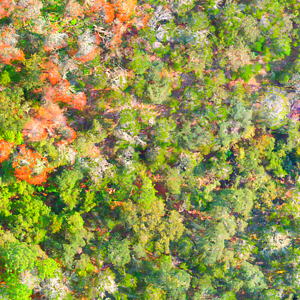

In [6]:
from PIL import ImageEnhance
saturation = ImageEnhance.Color(trees)
factor = 5
saturated = saturation.enhance(factor)
display(saturated)

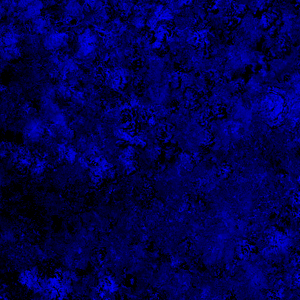

In [19]:
# check out a single channel
channel = saturated.copy()
pixels = channel.load()
w, h =  channel.size
for row in range(h):
  for column in range(w):
    (red, green, blue) = pixels[column, row]
    pixels[column, row] = (0, 0, blue)
display(channel)

The red trees stand out now. Let's focus on those. (Why would this be helpful for someone studying the forest health?)

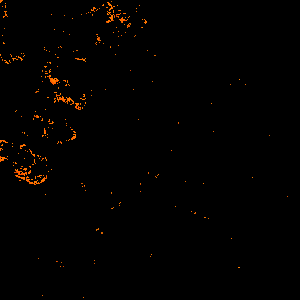

In [7]:
reds = saturated.copy()
pixels = reds.load()
w, h = reds.size
threshold = 200
for row in range(h):
  for column in range(w):
    (red, green, blue) = pixels[column, row]
    if red > threshold and red > 2 * green and red > 2 * blue:
      pixels[column, row] = (red, green, 0) # ditch the blue channel
    else:
      pixels[column, row] = (0, 0, 0) # black if red not dominant
display(reds)

We can apply *filters* on the image to create larger "islands".

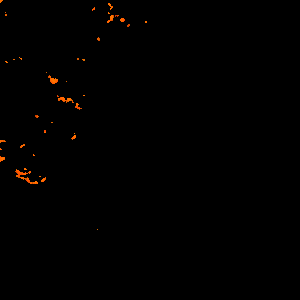

In [9]:
from PIL import ImageFilter
median = reds.filter(ImageFilter.MedianFilter(size = 3))
display(median)

The *median* (used above) is but one among many options.

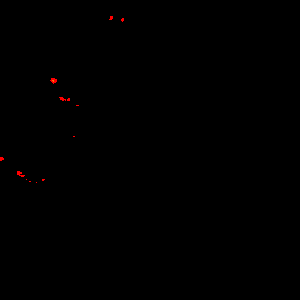

In [10]:
mode = reds.filter(ImageFilter.ModeFilter(size = 5))
display(mode)

We can then *overlay* the filtered one onto the original photo to highlight trouble spots.

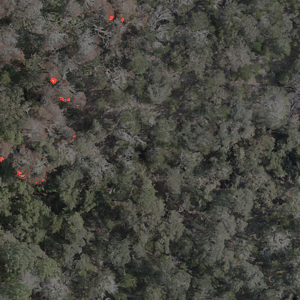

In [ ]:
trees = trees.convert('RGB')
overlay = Image.blend(trees, mode, 0.5) # try the median, too
display(overlay)

The above steps are more along the lines of image processing as a discipline. **Computer vision** goes one step further: trying to identify what the image contains in order to have something (an autonomous vehicle? a robotic arm?) interact with what it "sees" in its field of vision.

In [11]:
!pip install -q opencv-python # we ask the OPERATING SYSTEM to add a package that we need to access (that is not there by default since it is heavy)

In [12]:
import numpy as np
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow # colab is special, we would not do this last thing if we used cv2 on our own computers

Let's again load an image from the internet.

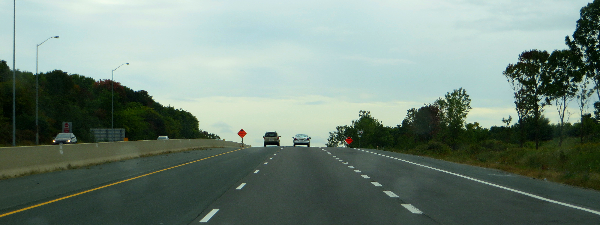

In [13]:
from urllib.request import urlopen
src = 'https://upload.wikimedia.org/wikipedia/commons/3/35/Ontario_Highway_401%2C_Near_Colbourne%2C_Ontario_%2829985970881%29.jpg'
req = urlopen(src)
arr = np.asarray(bytearray(req.read()), dtype = np.uint8)
img = cv2.imdecode(arr, -1)
oh, ow, ch = img.shape
width = 600 # again we want it small for speed
height = int(width * oh / ow)
img = cv2.resize(img, (width, height)) # keep the aspect ratio
cv2_imshow(img)

The first step is often *eliminating* information in order to focus on some relevant aspect of the scene. (We can then overlay things to bring it back, of course).

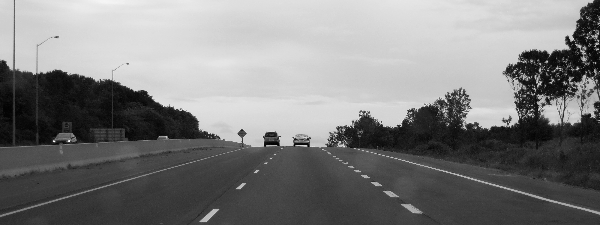

In [14]:
gr = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # use grayscale colors instead
cv2_imshow(gr)

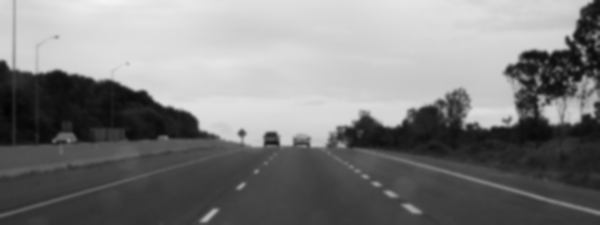

In [ ]:
blur = cv2.GaussianBlur(gr, (7, 7), 0) # noise reduction
cv2_imshow(blur)

If we wanted to know, let's say, where the lanes and the vehicles are, we would be interested in the *edges* of the visible objects.

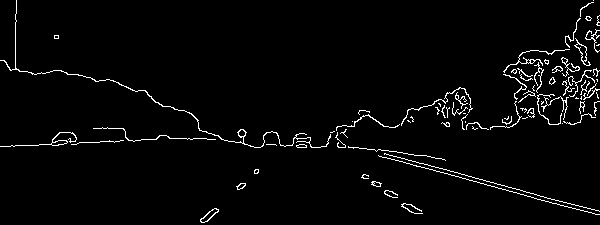

In [ ]:
edges = cv2.Canny(blur, 50, 150)
cv2_imshow(edges)

Let's highlight these edges in bright red on the original image.

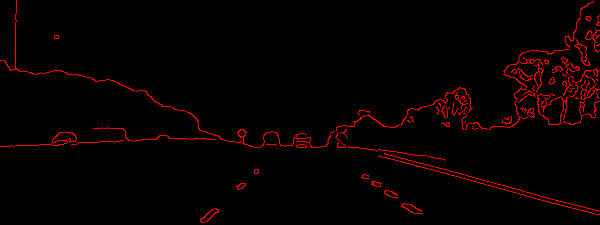

In [ ]:
rgb = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB) # grayscale to RGB

blacks = np.sum(rgb, axis = -1) == 0 # the locations of the [0, 0, 0] pixels
whites = np.all(rgb, axis = -1) > 0 # the locations of the [255, 255, 255] pixels

transparency = np.uint8(blacks * 255)
tp = np.dstack((rgb, transparency))

tp[np.where(whites)] = (0, 0, 255, 255) # opencv orders them BGR for... reasons...
cv2_imshow(tp)

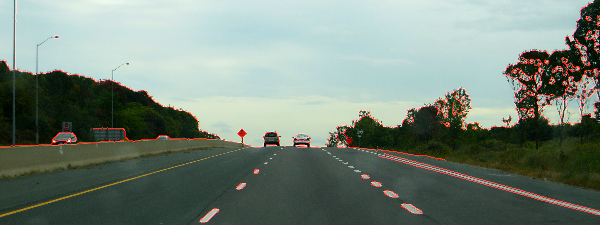

In [ ]:
rgba = cv2.cvtColor(img, cv2.COLOR_RGB2RGBA)

combo = cv2.addWeighted(rgba, 1, tp, 1, 0)

cv2_imshow(combo)

## How about text?

Pictures are supposed to be worth a thousand words but often we end up with datasets that contain words. We can process those, too (and make pictures of them if we really want to.)

In [ ]:
!pip install gutenbergpy # another extra functionality that we need to request to add to the operating system

We can download whole books from the internet, which is cool.

In [ ]:
target = 1342 # pride and prejudice
import gutenbergpy.textget
raw  = gutenbergpy.textget.get_text_by_id(target) # access the book content
content = gutenbergpy.textget.strip_headers(raw) # remove header metadata
text = content.decode("utf-8") # encoding of the content

Just like with the images above, working with the entire dataset might be a bit too heavy for practice purposes.

In [ ]:
fragment = text[55000:57000]
print(fragment) # let's see some of it

 you like this man’s sisters,
too, do you? Their manners are not equal to his.”

“Certainly not, at first; but they are very pleasing women when you
converse with them. Miss Bingley is to live with her brother, and keep
his house; and I am much mistaken if we shall not find a very charming
neighbour in her.”

Elizabeth listened in silence, but was not convinced: their behaviour at
the assembly had not been calculated to please in general; and with more
quickness of observation and less pliancy of temper than her sister, and
with a judgment, too, unassailed by any attention to herself, she was
very little disposed to approve them. They were, in fact, very fine
ladies; not deficient in good-humour when they were pleased, nor in the
power of being agreeable where they chose it; but proud and conceited.
They were rather handsome; had been educated in one of the first private
seminaries in town; had a fortune of twenty thousand pounds; were in the
habit of spending more than they ought, and

Text processing tends to start by cleaning up elements of the next so that we can grasp what the text seems to be about without getting lost in the noise.

In [ ]:
from string import punctuation
import re # regular expressions
from string import printable

print('Allow these:', printable)
forbid = f'[^{re.escape(printable)}]' # everything else must go

removed = fragment.translate(str.maketrans(punctuation, ' ' * len(punctuation))) # substitute with space
better = re.sub(forbid, ' ', removed)
clean = re.compile(r'\s+')
ok = clean.sub(' ', better) # remove repeated spaces
print(ok)

Allow these: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

 you like this man s sisters too do you Their manners are not equal to his Certainly not at first but they are very pleasing women when you converse with them Miss Bingley is to live with her brother and keep his house and I am much mistaken if we shall not find a very charming neighbour in her Elizabeth listened in silence but was not convinced their behaviour at the assembly had not been calculated to please in general and with more quickness of observation and less pliancy of temper than her sister and with a judgment too unassailed by any attention to herself she was very little disposed to approve them They were in fact very fine ladies not deficient in good humour when they were pleased nor in the power of being agreeable where they chose it but proud and conceited They were rather handsome had been educated in one of the first private seminaries in town had a fortune 

Before working with sentences, paragraphs, chapters, the most common starting point are individual words.

In [ ]:
words = ok.split()

def keep(word):
  return not word.isupper()

good = list(filter(keep, words))
print(good)

['you', 'like', 'this', 'man', 's', 'sisters', 'too', 'do', 'you', 'Their', 'manners', 'are', 'not', 'equal', 'to', 'his', 'Certainly', 'not', 'at', 'first', 'but', 'they', 'are', 'very', 'pleasing', 'women', 'when', 'you', 'converse', 'with', 'them', 'Miss', 'Bingley', 'is', 'to', 'live', 'with', 'her', 'brother', 'and', 'keep', 'his', 'house', 'and', 'am', 'much', 'mistaken', 'if', 'we', 'shall', 'not', 'find', 'a', 'very', 'charming', 'neighbour', 'in', 'her', 'Elizabeth', 'listened', 'in', 'silence', 'but', 'was', 'not', 'convinced', 'their', 'behaviour', 'at', 'the', 'assembly', 'had', 'not', 'been', 'calculated', 'to', 'please', 'in', 'general', 'and', 'with', 'more', 'quickness', 'of', 'observation', 'and', 'less', 'pliancy', 'of', 'temper', 'than', 'her', 'sister', 'and', 'with', 'a', 'judgment', 'too', 'unassailed', 'by', 'any', 'attention', 'to', 'herself', 'she', 'was', 'very', 'little', 'disposed', 'to', 'approve', 'them', 'They', 'were', 'in', 'fact', 'very', 'fine', 'ladi

Some words appear often in all texts no matter the topic, so we like to clean those out.

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
sw = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def keep2(w):
  return not (w.lower() in sw) and not (w.isdigit())

better = list(filter(keep2, good))
print(better)

['like', 'man', 'sisters', 'manners', 'equal', 'Certainly', 'first', 'pleasing', 'women', 'converse', 'Miss', 'Bingley', 'live', 'brother', 'keep', 'house', 'much', 'mistaken', 'shall', 'find', 'charming', 'neighbour', 'Elizabeth', 'listened', 'silence', 'convinced', 'behaviour', 'assembly', 'calculated', 'please', 'general', 'quickness', 'observation', 'less', 'pliancy', 'temper', 'sister', 'judgment', 'unassailed', 'attention', 'little', 'disposed', 'approve', 'fact', 'fine', 'ladies', 'deficient', 'good', 'humour', 'pleased', 'power', 'agreeable', 'chose', 'proud', 'conceited', 'rather', 'handsome', 'educated', 'one', 'first', 'private', 'seminaries', 'town', 'fortune', 'twenty', 'thousand', 'pounds', 'habit', 'spending', 'ought', 'associating', 'people', 'rank', 'therefore', 'every', 'respect', 'entitled', 'think', 'well', 'meanly', 'others', 'respectable', 'family', 'north', 'England', 'circumstance', 'deeply', 'impressed', 'memories', 'brother', 'fortune', 'acquired', 'trade', 'M

One way to visualize text is making a *word cloud*.

In [ ]:
!pip install wordcloud # add another tool

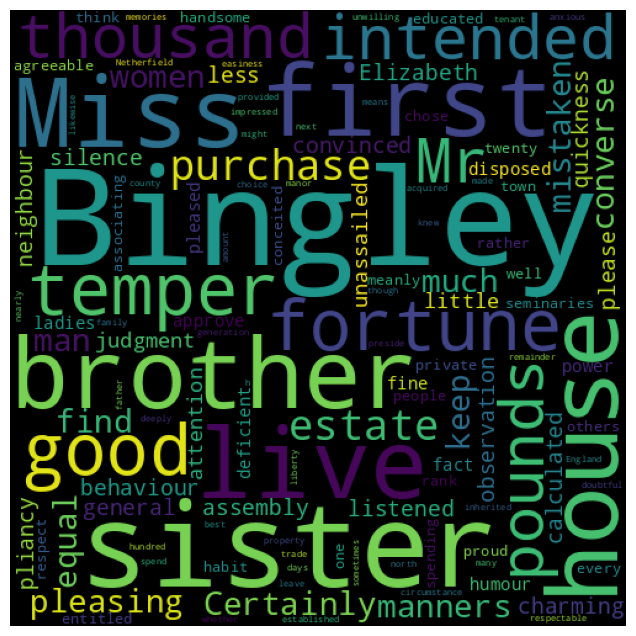

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]

from wordcloud import WordCloud
t = ' '.join(better)
cloud = WordCloud(width = 500, height = 500).generate(t)
plt.imshow(cloud)
plt.axis('off')
plt.show()

We can also return to network analysis (a personal favorite) using the positions of words within text as the edges and the words themselves as the vertices.

In [ ]:
import networkx as nx

graph = nx.DiGraph()
sequence = better.copy()

currentWord = sequence.pop(0)
while len(sequence) > 0:
  followingWord = sequence.pop(0)
  if graph.has_edge(currentWord, followingWord):
    graph[currentWord][followingWord]['weight'] += 1
  else:
    graph.add_edge(currentWord, followingWord, weight = 1)
  currentWord = followingWord

print(graph)

DiGraph with 130 nodes and 144 edges


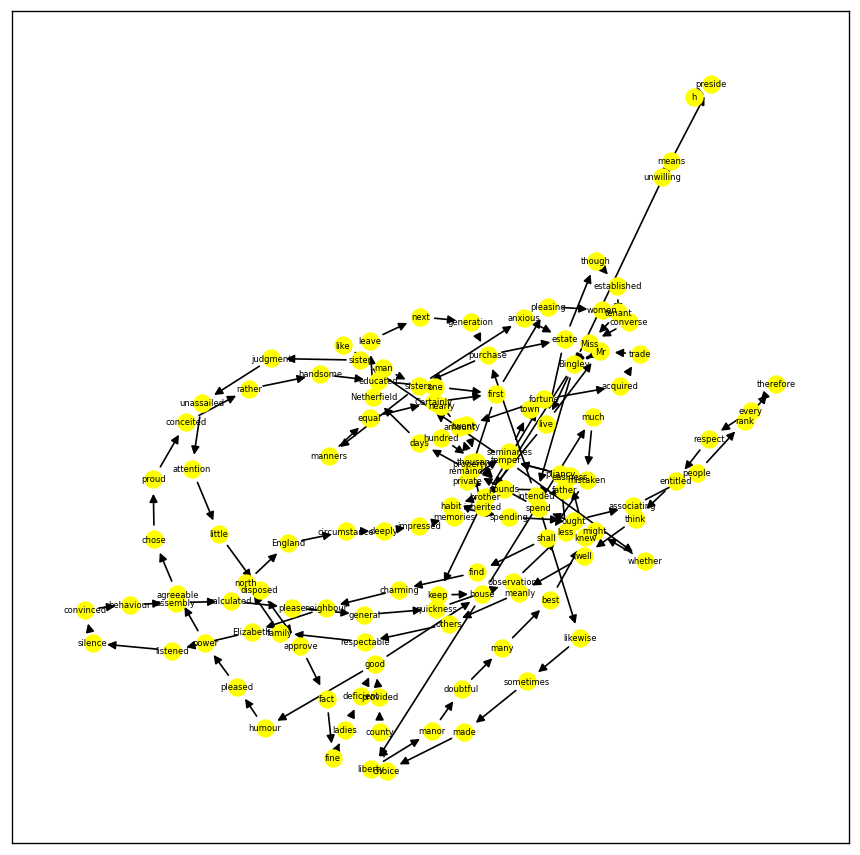

In [ ]:
pos = nx.spring_layout(graph)
import matplotlib.pyplot as plt
fig = plt.figure(1, figsize = (9, 9), dpi =  120)
V = nx.draw_networkx_nodes(graph, pos, node_size = 100, node_color = 'yellow')

w = [ graph[u][v]['weight'] for u, v in graph.edges ]
E = nx.draw_networkx_edges(graph, pos, width = w)
vl = nx.draw_networkx_labels(graph, pos, font_size = 5)

More advances techniques that go deeper into the context and semantics include *sentiment analysis*.

In [ ]:
from transformers import pipeline
sentiment_pipeline = pipeline(model = 'finiteautomata/bertweet-base-sentiment-analysis') # this will be SLOW and print out a lot of progress bars

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Device set to use cpu


In [ ]:
inputs = [ 'This is great 😊 I got it as a gift and I absolutely love it, very useful.', 'This is the worst purchase I have ever made, total waste of money 😔']
outputs = sentiment_pipeline(inputs)

In [ ]:
for (i, o) in zip(inputs, outputs):
  print(i, o)

This is great 😊 I got it as a gift and I absolutely love it, very useful. {'label': 'POS', 'score': 0.992657482624054}
This is the worst purchase I have ever made, total waste of money 😔 {'label': 'NEG', 'score': 0.9835191369056702}
